In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import expectation_reflection as ER
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
# load data
df = pd.read_csv('../diabetic_retinopathy_data.txt',sep= ',',header=None)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1


In [5]:
#df.info()

There are 25 attributes: <br/>
0) quality assessment: 1 = sufficient quality, 0 = bad quality --> binary <br/>
1) pre-screening: 1 = retinal abnormal, 0 = lack --> binary <br/>
2) (2-->7): MA detection: number of MAs found at the confidence levels alpha = 0.5, . . . , 1, respectively --> numerical <br/>
8) (8-->15) Exudates: normalized by dividing the number of lesions with the diameter of the ROI to compensate different image sizes --> numerical<br/>
16) euclidean distance --> numerical<br/>
17) The diameter of the optic disc --> numerical<br/>
18) The binary result of the AM/FM-based classification --> NOT use this result.

and 1 class: 1 (diabetic retinopathy) and 0 (not diabetic retinophathy)

In [6]:
df = np.array(df).astype(float)
df.shape

(1151, 20)

In [7]:
np.unique(df[:,0],return_counts=True)

(array([0., 1.]), array([   4, 1147]))

In [8]:
# delete bad rows
df = df[df[:,0] ==1]
df.shape

(1147, 20)

In [9]:
X = df[:,1:-2] # not take the quality assessment (column 0) and AM/FM classification (column 18)
X.shape

(1147, 17)

In [10]:
y = df[:,-1]
np.unique(y,return_counts=True)

(array([0., 1.]), array([536, 611]))

In [11]:
# convert 1, 0 to 1, -1:
X[:,0] = 2*X[:,0] - 1
y = 2*y - 1

In [12]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

In [13]:
np.savetxt('../diabeticretinopathy_X.txt',X,fmt='%f')
np.savetxt('../diabeticretinopathy_y.txt',y,fmt='%f')

In [14]:
def inference(X_train,y_train,X_test,y_test,method='expectation_reflection'):
    if method == 'expectation_reflection':
        h0,w = ER.fit(X_train,y_train,niter_max=20,regu=0.)
        y_pred = ER.predict(X_test,h0,w)

    else:
        if method == 'logistic_regression':
            model = LogisticRegression(solver='liblinear')

        if method == 'naive_bayes': 
            model = GaussianNB()

        if method == 'random_forest':
            model = RandomForestClassifier(criterion = "gini", random_state = 1,
                           max_depth=3, min_samples_leaf=5,n_estimators=100)   
            
        if method == 'decision_tree':
            model = DecisionTreeClassifier()  

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test,y_pred)                
                  
    return accuracy

In [15]:
def compare_inference(X,y,train_size):
    npred = 100
    accuracy = np.zeros((len(list_methods),npred))
    precision = np.zeros((len(list_methods),npred))
    recall = np.zeros((len(list_methods),npred))
    accuracy_train = np.zeros((len(list_methods),npred))
    for ipred in range(npred):
        #X, y = shuffle(X, y)
        X_train0,X_test,y_train0,y_test = train_test_split(X,y,test_size=0.2,random_state = ipred)
        idx_train = np.random.choice(len(y_train0),size=int(train_size*len(y)),replace=False)
        X_train,y_train = X_train0[idx_train],y_train0[idx_train]

        for i,method in enumerate(list_methods):
            accuracy[i,ipred] = inference(X_train,y_train,X_test,y_test,method)
            
    return accuracy.mean(axis=1),accuracy.std(axis=1)

In [16]:
list_train_size = [0.8,0.6,0.4,0.2]
list_methods=['logistic_regression','naive_bayes','random_forest','decision_tree','expectation_reflection']
acc = np.zeros((len(list_train_size),len(list_methods)))
acc_std = np.zeros((len(list_train_size),len(list_methods)))
for i,train_size in enumerate(list_train_size):
    acc[i,:],acc_std[i,:] = compare_inference(X,y,train_size)
    print(train_size,acc[i,:])

0.8 [0.65621739 0.55956522 0.64147826 0.61134783 0.73773913]
0.6 [0.65113043 0.56204348 0.64073913 0.60395652 0.73765217]
0.4 [0.64126087 0.56365217 0.64304348 0.59895652 0.73321739]
0.2 [0.62052174 0.57052174 0.62943478 0.59208696 0.72217391]


In [17]:
df = pd.DataFrame(acc,columns = list_methods)
df.insert(0, "train_size",list_train_size, True)
df

,train_size,logistic_regression,naive_bayes,random_forest,decision_tree,expectation_reflection
0,0.8,0.656217,0.559565,0.641478,0.611348,0.737739
1,0.6,0.651130,0.562043,0.640739,0.603957,0.737652
2,0.4,0.641261,0.563652,0.643043,0.598957,0.733217
3,0.2,0.620522,0.570522,0.629435,0.592087,0.722174


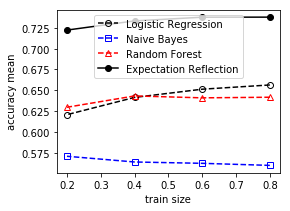

In [18]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc[:,2],'r--',marker='^',mfc='none',label='Random Forest')
plt.plot(list_train_size,acc[:,4],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy mean')
plt.legend()

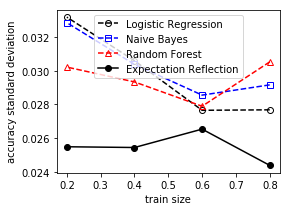

In [19]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc_std[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc_std[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc_std[:,2],'r--',marker='^',mfc='none',label='Random Forest')
plt.plot(list_train_size,acc_std[:,4],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy standard deviation')
plt.legend()

In [20]:
np.savetxt('../diabeticretinopathy_acc.txt',acc,fmt='%f')
np.savetxt('../diabeticretinopathy_acc_std.txt',acc_std,fmt='%f')